In [27]:
%load_ext autoreload
%autoreload 2
# %cd /p/mmcardiac/Jerry/code/CINE-DENSE-Translation
# %cd /home/jx8fh/Projects/LaMoD
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from modules.data import check_dict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD


In [28]:
# USE GPU 0
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1. Load Data

In [29]:
test_fname = '/scratch/jx8fh/2024-06-22-MICCAI-ShapeMI-Workshop-data/lamod_test.npy'
test_data = np.load(test_fname, allow_pickle=True).tolist()

In [30]:
check_dict(test_data[0])

ori_n_frames                                                 51                  
augmented                                                    False               
DENSE_slice_mat_filename                                     /p/miauva/data/Jerry/medical-images/Cardiac-FromKen/Yu-DENSE-data/033_S01_base_auto.1_ROI.1.mat
DENSE_slice_location                                         76.947609505431     
subject_id                                                   033-DENSE           
slice_idx                                                    31                  
slice_full_id                                                033-31              
full_name                                                    033-DENSE_31        
DENSE_disp                                                   (2, 40, 48, 48)     
myo_masks                                                    (1, 40, 128, 128)   


# 2. Load Config

In [31]:
import json
config_fname = 'configs/ours-LaMoD.json'
config = json.load(open(config_fname))

# 3. Build Model

In [32]:
from models.LaMoD import LaMoD
network = LaMoD(config['networks'], device).to(device)

Skip connect: False
Loading pretrained model from checkpoints/ours_registration.pth
Unrecognized keyword argument: beta_schedule_overwrite = True
Unrecognized keyword argument: load_pretrained = True
Unrecognized keyword argument: pretrained_model_path = checkpoints/ours_latent_diffusion.pth
beta_schedule_method='linear'
Loading pretrained model from checkpoints/ours_latent_diffusion.pth
Overwriting beta schedule with linear schedule with scale 30
ignorekwargs: {'type': 'DiffusionDecoder', 'drouput': 0.3, 'load_pretrained': True, 'pretrained_model_path': 'checkpoints/ours_motion_regression.pth'}
Decoder tanh_out:  False
Decoder: give_pre_end=False, tanh_out=False, out_scaling_factor=1
Working with z of shape (1, 16, 16, 16) = 4096 dimensions.
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of typ

# 4. Inference

## 4.1 Displacement Field

In [33]:
from skimage.transform import resize
check_data_idx = 0
inference_mask = torch.from_numpy(
    resize(test_data[check_data_idx]['myo_masks'][0,0]>0.5, [48,48], anti_aliasing=False)
)

In [34]:
test_data[0]['myo_masks'].shape

(1, 40, 128, 128)

In [59]:
check_data_idx = 0

# Prepare Pytorch tensor
inference_input_video      = torch.from_numpy(test_data[check_data_idx]['myo_masks']).to(device)
inference_input_video_ori_frame = test_data[check_data_idx]['ori_n_frames']
inference_output_dict = network.inference(
    inference_input_video, 
    ori_n_frames=[inference_input_video_ori_frame])[0]

# Extract prediction
inference_disp = inference_output_dict['LaMoD_disp'].detach().cpu()

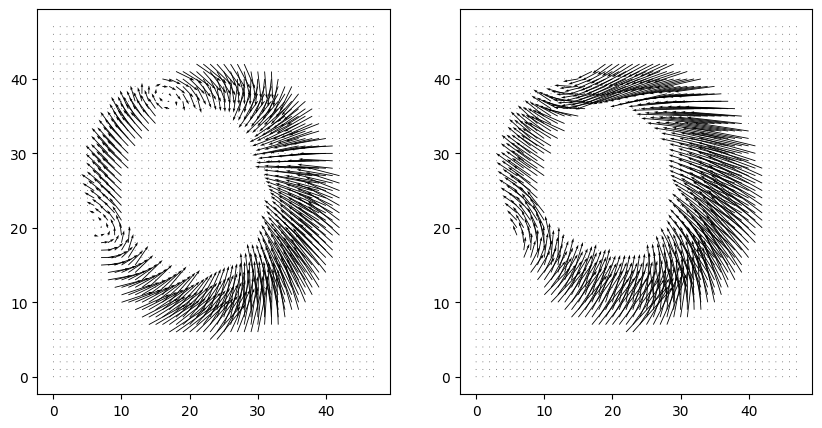

In [60]:
# Visualize 
check_frame_idx = 20
fig, axs = plt.subplots(1, 2, figsize=(10,5))
# Prediction
axs[0].quiver(
    inference_disp[0,0,check_frame_idx]*inference_mask,
    inference_disp[0,1,check_frame_idx]*inference_mask,
    units='xy',
    scale=1
)
# DENSE GT
axs[1].quiver(
    test_data[check_data_idx]['DENSE_disp'][0,check_frame_idx],
    test_data[check_data_idx]['DENSE_disp'][1,check_frame_idx],
    units='xy',
    scale=1
)

## 4.2 Strain Image

In [61]:
inference_disp.shape

torch.Size([1, 2, 39, 48, 48])

In [62]:
test_data[check_data_idx]['DENSE_disp'].shape

(2, 40, 48, 48)

In [63]:
np.moveaxis(inference_disp[0,0].numpy(), 0, -1).shape

(48, 48, 39)

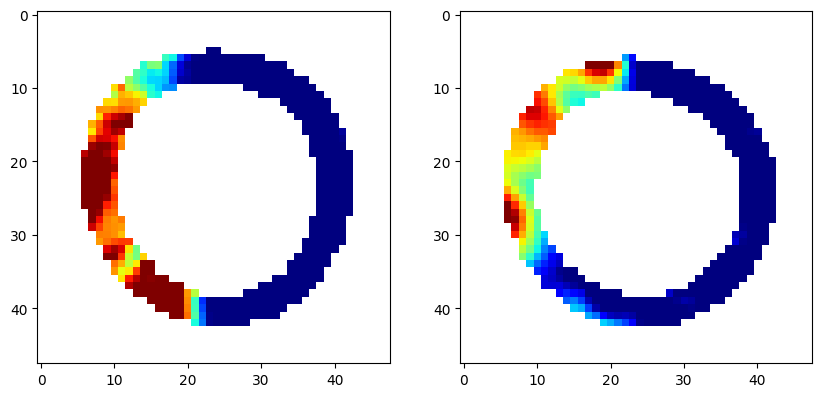

In [64]:
from modules.data.processing.strain_analysis.pixelstrain import pixelstrain

H, W = inference_disp.shape[-2:]
X, Y = np.meshgrid(np.arange(W), np.arange(H))
dXt = np.moveaxis(inference_disp[0,0].numpy(), 0, -1)
dYt = np.moveaxis(inference_disp[0,1].numpy(), 0, -1)
mask = inference_mask.numpy()
Nfr = inference_disp.shape[2]
strain = pixelstrain(
    X=X, Y=Y, 
    dXt=dXt, dYt=dYt, 
    mask=mask, times=np.arange(Nfr))
mask_GT = (np.abs(test_data[check_data_idx]['DENSE_disp'][0][0]) + np.abs(test_data[check_data_idx]['DENSE_disp'][1][0])) > 0
strain_GT = pixelstrain(
    X=X, Y=Y, 
    dXt=np.moveaxis(test_data[check_data_idx]['DENSE_disp'][0], 0, -1), 
    dYt=np.moveaxis(test_data[check_data_idx]['DENSE_disp'][1], 0, -1), 
    mask=mask_GT, times=np.arange(Nfr))
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(strain['CC'][...,check_frame_idx], cmap='jet', vmin=-0.2, vmax=0.2)
axs[1].imshow(strain_GT['CC'][...,check_frame_idx], cmap='jet', vmin=-0.2, vmax=0.2)